# Cas d'étude : Detection de tumeurs canceureuses

- Objectif **Améliorer la rapidité et la précision de la détection de tumeur cérébrale sur la base d'image IRM**.

- On espère être pro-actif dans la détéction de futur tumeurs

- Problème de détéction : classification + localization

  - Il y aura 2 modèle 
    - ->Si une tumeur existe
    - ->Si elle existe segmenter (ResUnet) l'image pour la trouver

    ![Image](http://howtotreatcancer.com/wp-content/uploads/2015/10/brain_tumors.jpg)

- # Préambule

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd '/gdrive/My Drive/NeuralNets/ANN Practices/IA & Sante'

Mounted at /gdrive
/gdrive/My Drive/NeuralNets/ANN Practices/IA & Sante


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob
import random

import PIL
from PIL import *
import pickle 

import zipfile
from skimage import io

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras import *
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPool2D, Add, AveragePooling2D, Dropout, ZeroPadding2D
from keras.models import Model
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler, normalize

from IPython.display import display

- # Importation des données

In [ ]:
brain_df = pd.read_csv('Brain_MRI/data_mask.csv')
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


- Un peu d'infos

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df['image_path'][0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif'

- Les données sont elles équilibré (auantant de cas avec et sans tumurs)

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

- Graphique

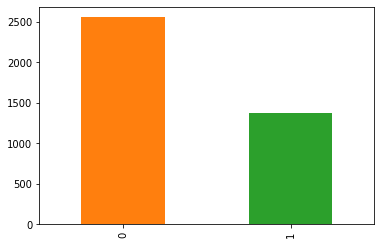

In [ ]:
brain_df['mask'].value_counts().plot(kind = 'bar', color = ['C1', 'C2'])

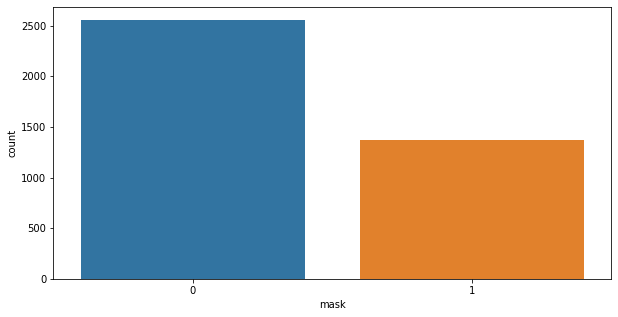

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'mask', data = brain_df, order = brain_df['mask'].value_counts().index)

**-- On est un peu déséquilibré ... Quasiment le 2x d"échantillon pour les cas négatifs** 

- # Undersampling

In [ ]:
# Selectionner les éléments a retirer
to_erase = random.choices(brain_df[brain_df["mask"] == 0].index, k = 600)

# Retirer les éléments du DataFrame
new_brain_df = brain_df.drop(index = to_erase, axis=0)

new_brain_df['mask'].value_counts()

0    2030
1    1373
Name: mask, dtype: int64

- # Data Visualization

- Pour cette version, on va utiliser plotly (jamais utilisé) pour plot graphe intéractif

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data = [go.Bar( x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())]) # index = 0 ou 1
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(255,0,0)', marker_line_width = 3, opacity = 0.6)

fig.show()

- Sanity check sur les images

  - Positifs

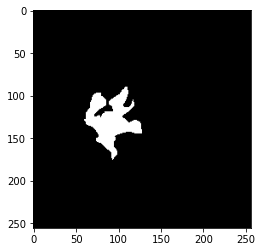

In [ ]:
plt.imshow(plt.imread('Brain_MRI/' + brain_df[brain_df['mask'] == 1].reset_index()['mask_path'][random.randint(0, 1376)]), cmap = 'gray')

- Négatifs

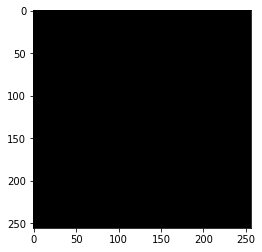

In [ ]:
plt.imshow(plt.imread('Brain_MRI/' + brain_df[brain_df['mask'] == 0].reset_index()['mask_path'][random.randint(0, 2556)]), cmap = 'gray')

In [ ]:
brain_df[brain_df['mask'] == 1].reset_index().head(5)

,index,patient_id,image_path,mask_path,mask
0,445,TCGA_DU_5872_19950223,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...,1
1,507,TCGA_DU_5874_19950510,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...,1
2,551,TCGA_DU_5854_19951104,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...,1
3,555,TCGA_DU_5854_19951104,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1
4,617,TCGA_DU_5853_19950823,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...,1


- Random plot

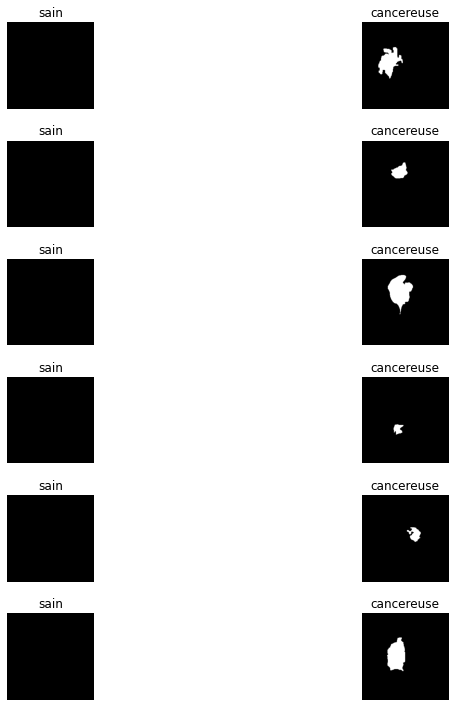

In [ ]:
fig, axs = plt.subplots(nrows = 6, ncols = 2, figsize = (10, 10))
fig.tight_layout()

for i in range(6):
    for j in range(2): # 0 --> 1
      
      x = brain_df[brain_df['mask'] == j] #  Donne une liste de valeur booleene (une pour chaque valeur du vecteur), x_train[y_train == j] la valeur booléene nous dit deprendre ou de ne pas prendre l'image en fonction de l'expression évalué  
      
      # axs[i][j].title.set_text('Brain-MRI')
      axs[i][j].imshow(plt.imread('Brain_MRI/' + np.random.choice(x['mask_path']) ), cmap = 'gray') # Choisir une image random parmis à True d'ou le random.randint 
      axs[i][j].axis("off")


      if j == 0:
        axs[i][j].set_title('sain')
      else:
        axs[i][j].set_title('cancereuse')

- Brain + Mask (Sick)

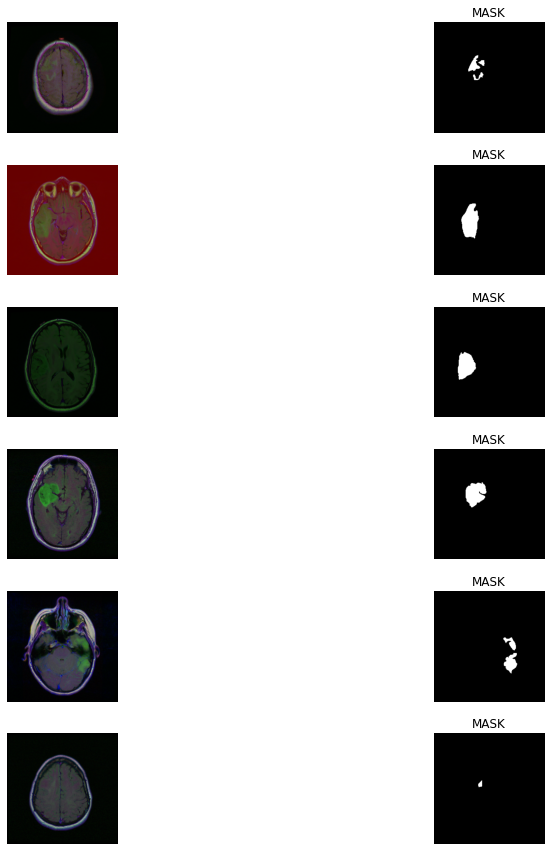

In [ ]:
fig, axs = plt.subplots(nrows = 6, ncols = 2, figsize = (12, 12))
fig.tight_layout()

for i in range(6):
      
      x = brain_df[brain_df['mask'] == 1].reset_index() #  Donne une liste de valeur booleene (une pour chaque valeur du vecteur), x_train[y_train == j] la valeur booléene nous dit deprendre ou de ne pas prendre l'image en fonction de l'expression évalué  
      
      # axs[i][j].title.set_text('Brain-MRI')

      idx = random.randint(0, len(x))

      # IRM
      axs[i][0].imshow( plt.imread('Brain_MRI/' + x['image_path'][idx] ), cmap = 'gray') # Choisir une image random parmis à True d'ou le random.randint 
      axs[i][0].axis("off")

      # Mask Associé
      axs[i][1].imshow( plt.imread('Brain_MRI/' + x['mask_path'][idx] ), cmap = 'gray') # Choisir une image random parmis à True d'ou le random.randint 
      axs[i][1].axis("off")


      if j == 0:
        axs[i][0].set_title('BRAIN IRM')
      else:
        axs[i][1].set_title('MASK')

- Combiner dans une 3ième colonne les IRM + mask et souligner la tumeur en rouge

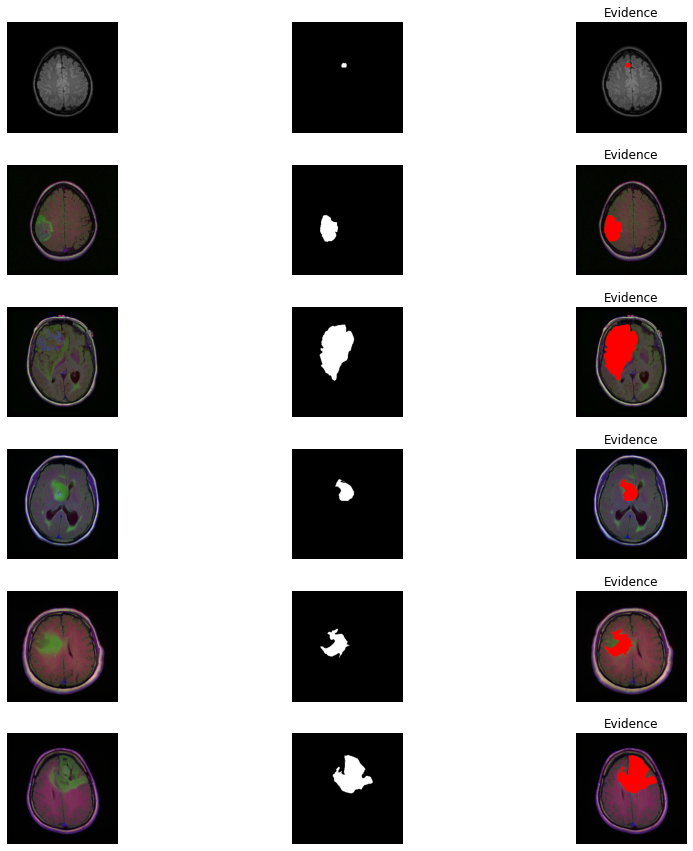

In [ ]:
fig, axs = plt.subplots(nrows = 6, ncols = 3, figsize = (12, 12))
fig.tight_layout()

for i in range(6):
      
      x = brain_df[brain_df['mask'] == 1].reset_index() #  Donne une liste de valeur booleene (une pour chaque valeur du vecteur), x_train[y_train == j] la valeur booléene nous dit deprendre ou de ne pas prendre l'image en fonction de l'expression évalué  
      
      # axs[i][j].title.set_text('Brain-MRI')

      idx = random.randint(0, len(x))

      irm = np.array( plt.imread('Brain_MRI/' + x['image_path'][idx] ) )
      msk = np.array( plt.imread('Brain_MRI/' + x['mask_path'][idx] ) )

      # IRM
      axs[i][0].imshow( irm , cmap = 'gray') # Choisir une image random parmis à True d'ou le random.randint 
      axs[i][0].axis("off")

      # Mask Associé
      axs[i][1].imshow( msk , cmap = 'gray') # Choisir une image random parmis à True d'ou le random.randint 
      axs[i][1].axis("off")

      # Evidence/IRM
      axs[i][2].imshow( evidence(irm, msk ), cmap = 'gray') # Choisir une image random parmis à True d'ou le random.randint 
      axs[i][2].axis("off")

      # version +rapide
      """
      irm[msk == 255] = (255, 0, 0)
      axs[i][2].imshow( irm, cmap = 'gray') # Choisir une image random parmis à True d'ou le random.randint 
      axs[i][2].axis("off")
      """

      if j == 0:
        axs[i][0].set_title('BRAIN IRM')
      elif j == 1:
        axs[i][1].set_title('MASK')
      else:
        axs[i][2].set_title('Evidence')

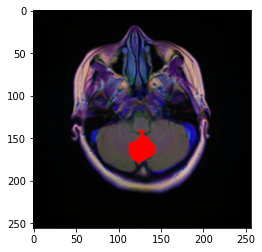

In [ ]:
x = brain_df[brain_df['mask'] == 1].reset_index().head(2)

irm = np.array(plt.imread( 'Brain_MRI/' + x['image_path'][1] ))
msk = np.array(plt.imread( 'Brain_MRI/' + x['mask_path'][1] ))

# il faut que pour les couche Bleu et vert pour la région concerné je mette les pixel à 0 et rouge à 255
for channel in range(0, 3):
  for i in range(len(msk)):
    for j in range(len(msk)):
      if msk[i, j] > 0:
        if channel != 0:
          irm[i, j, channel] = 0
        else:
          irm[i, j, channel] = 255

plt.imshow( irm )

In [ ]:
# En fonction
def evidence(irm, mask):

  """
    Mise en evidence du mask sur l'IRm par superposition
  """
  # il faut que pour les couche Bleu et vert pour la région concerné je mette les pixel à 0 et rouge à 255
  for channel in range(0, 3):
    for i in range(len(msk)):
      for j in range(len(msk)):
        if msk[i, j] > 0:
          if channel != 0:
            irm[i, j, channel] = 0
          else:
            irm[i, j, channel] = 255

  return irm

- # Construction du modèle / Transfer Learning

- TRANSFER LEARNING  ||  Transfert de Connaissances

On coupe la partie "full-connected", car on doit lui apprendre a ré-arranger/combier autrement les features pour pouvoir s'adapter au nouveau contexte

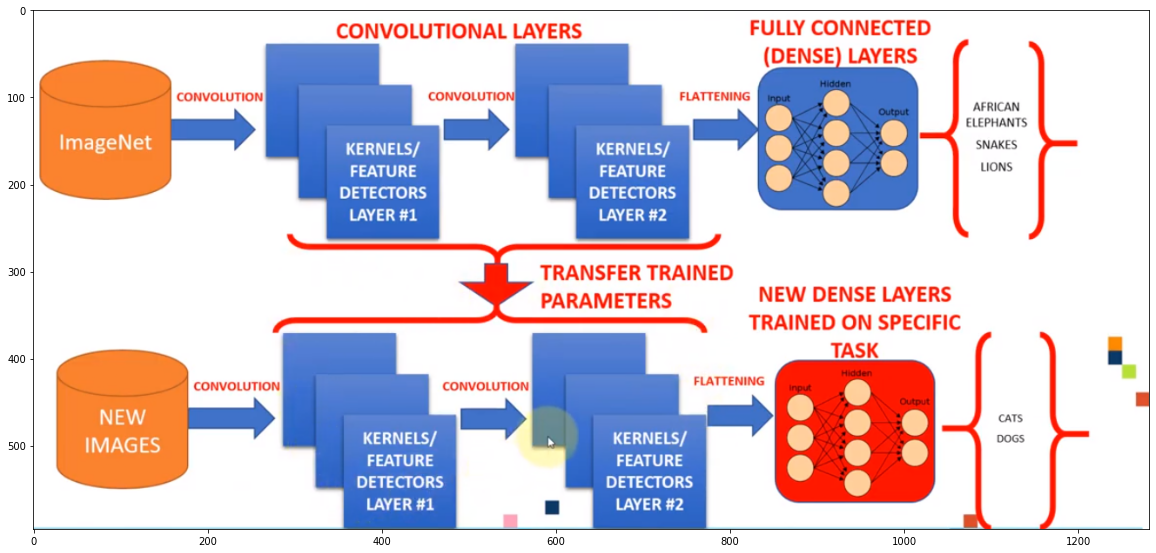

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread('tl.png'))

  - Stratégie 1 Steps:
    - "Geler" les poids de la partie CNN
    - Entrainer la couche full ajouter with randim init weights

  - Stratégie 2 Steps:
    - Ne pas "Geler" les poids de la partie CNN
    - On va < fine-tuned > les poids de la partie CNN
    - En re-entrainant le modèle "entièrement" mais avec un < Learning rate >, plus faible pour ne pas changer de manière aggressif ces derniers.


  - Avantages TF.
    - Entrainement rapide (on ne part pas de zéro)
    - Small training dataset needed to achieve great 
    
  - Attention !
    - Negative Tranfer : If the features are not common to both problems, then applying Transfer Learning becomes much more complex if possible at all.

    - Transfer Learning makes sense when we have a lot of data for the source task, and very little data for the posterior or target task. If we have the same amount of data for both tasks, then transfer learning does not make a lot of sense.

    - Quelle est la quantité de connaissnce transferé ? Justifie telle la robustesse du modèle ? Devrait-on considérer un autre modèle

  - Conclusion :  if you have a source task A, and a target task B

    - Task A and B have the same input x.
    - You have a lot more data for task A than for task B.
    - Low level features from task A must be helpful for learning task B. (If you try to learn to classify images of animals using transfer learning from a data set of clouds, the results might not be too great.)

In [ ]:
# Retirer la colonne id patient
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.head(5)

,image_path,mask_path,mask
0,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


 - Split Train/Test

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

- Créer un générateur d'image (Version avec erreur - keep for training purpose)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

# Générateur d'image dans un batch dont 15% pour la validation + scale data enre 0 et 1
datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(directory ='./Brain_MRI/', 
                                              target_size = (256, 256), 
                                              class_mode = 'binary', 
                                              batch_size = 16, # feed the image in batch format
                                              shuffle = True, # Important de mélanger afin que le modèle n'apprenne l'ordre des images, ce qui lui ferai croire qu'il y a un pattern prédictif dans la sucession d'images
                                              dataframe = train,
                                              x_col = 'image_path',
                                              y_col = 'mask',
                                              subset = 'training')

# Les 15%
valid_generator = datagen.flow_from_dataframe(directory ='./Brain_MRI/', 
                                              target_size = (256, 256), 
                                              class_mode = 'binary', 
                                              batch_size = 16, # feed the image in batch format
                                              shuffle = True,
                                              dataframe = train,
                                              x_col = 'image_path',
                                              y_col = 'mask',
                                              subset = 'validation')

# Pour test, j'utilise un autre générateur, car je ne veux pas diviser en valid la partie test qui est dejà un division de train
test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_dataframe(directory ='./Brain_MRI/', 
                                              target_size = (256, 256), 
                                              class_mode = 'binary', 
                                              batch_size = 16, # feed the image in batch format
                                              shuffle = True,
                                              dataframe = test,
                                              x_col = 'image_path',
                                              y_col = 'mask',
                                              subset = 'validation')

TypeError: ignored

- Créer un générateur d'image - Trop cher en RAM pour tout charger d'un coup
  - Note : Pour une version ultérieur on pourrait utiliser le nouveau format tf.data de tensorflow 2.0

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

"""
  Solution au problème
"""
brain_df_train['mask'] = brain_df_train['mask'].apply( lambda x : str(x) )

train, test = train_test_split(brain_df_train, test_size = 0.15)

# Générateur d'image dans un batch dont 15% pour la validation + scale data enre 0 et 1
datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(directory ='Brain_MRI/', 
                                              target_size = (256, 256), 
                                              class_mode = 'categorical', 
                                              batch_size = 16, # feed the image in batch format
                                              shuffle = True, # Important de mélanger afin que le modèle n'apprenne l'ordre des images, ce qui lui ferai croire qu'il y a un pattern prédictif dans la sucession d'images
                                              dataframe = train,
                                              x_col = 'image_path',
                                              y_col = 'mask',
                                              subset = 'training')

# Pour Les 15% validation subset
valid_generator = datagen.flow_from_dataframe(directory ='Brain_MRI/', 
                                              target_size = (256, 256), 
                                              class_mode = 'categorical', 
                                              batch_size = 16, # feed the image in batch format
                                              shuffle = True,
                                              dataframe = train,
                                              x_col = 'image_path',
                                              y_col = 'mask',
                                              subset = 'validation')

# Pour test, j'utilise un autre générateur, car je ne veux pas diviser en valid la partie test qui est dejà un division de train
test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                  directory ='Brain_MRI/',
                                                  x_col = 'image_path',
                                                  y_col = 'mask', 
                                              target_size = (256, 256), 
                                              class_mode = 'categorical', 
                                              batch_size = 16, # feed the image in batch format
                                              shuffle = True)

Found 2459 validated image filenames belonging to 2 classes.
Found 433 validated image filenames belonging to 2 classes.
Found 511 validated image filenames belonging to 2 classes.


- Apply TL

In [ ]:
basemodel = ResNet50(include_top = False, weights = 'imagenet', input_tensor = Input(shape = (256, 256, 3)))
basemodel.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

- figer les poids

In [ ]:
for layer in basemodel.layers:
  layer.trainable = False

- Ajouter notre couche connecté

In [ ]:
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPool2D, Add, AveragePooling2D, Dropout, ZeroPadding2D
from keras.models import Model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4), name = 'avegPool')(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(1024, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(512, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

- Compiler

In [ ]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

- Définir les callback d'arret et de Sauvegarde

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 5)

checkpoint = ModelCheckpoint(filepath= 'classifier2-resnet-weights.hdf5', verbose = 1, save_best_only = True)

- Train !

In [ ]:
h = model.fit(train_generator, steps_per_epoch = train_generator.n // 16, 
              epochs = 10, 
              validation_data = valid_generator, validation_steps = valid_generator.n // 16,
              callbacks = [early_stopping, checkpoint])

Epoch 1/10
177/177 [==============================] - 2630s 15s/step - loss: 0.6695 - accuracy: 0.7189 - val_loss: 0.6773 - val_accuracy: 0.6552

Epoch 00001: val_loss did not improve from 0.64374
Epoch 2/10
177/177 [==============================] - 2609s 15s/step - loss: 0.4221 - accuracy: 0.7923 - val_loss: 0.6194 - val_accuracy: 0.7520

Epoch 00002: val_loss improved from 0.64374 to 0.61945, saving model to classifier-resnet-weights.hdf5
Epoch 3/10
177/177 [==============================] - 2610s 15s/step - loss: 0.5559 - accuracy: 0.8032 - val_loss: 0.5773 - val_accuracy: 0.7702

Epoch 00003: val_loss improved from 0.61945 to 0.57726, saving model to classifier-resnet-weights.hdf5
Epoch 4/10
177/177 [==============================] - 2601s 15s/step - loss: 0.4049 - accuracy: 0.8084 - val_loss: 0.3700 - val_accuracy: 0.8306

Epoch 00004: val_loss improved from 0.57726 to 0.36998, saving model to classifier-resnet-weights.hdf5
Epoch 5/10
177/177 [==============================] - 25

- Save l'architecture

In [ ]:
model_json = model.to_json()
with open('classifier-resnet-archt.json', mode = 'w') as json_file:
  json_file.write(model_json)

- Charger un modèle

In [ ]:
with open('Brain_MRI/resnet-50-MRI.json', 'r') as json_file:
  json_saveModel = json_file.read()

modelbest = tf.keras.models.model_from_json(json_saveModel)
modelbest.load_weights('Brain_MRI/weights.hdf5')
modelbest.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

- ou re-entrainer le modele a prtir de là où il s'est arreté

In [ ]:
"""
# saving the model in tensorflow format
model.save('./MyModel_tf',save_format='tf')


# loading the saved model
loaded_model = tf.keras.models.load_model('./MyModel_tf')

# retraining the model
loaded_model.fit(x_train, y_train, epochs = 10, validation_data = (x_test,y_test),verbose=1)
"""

model.load_weights('classifier-resnet-weights.hdf5')

# retarin the model where it stop [3 epochs manquante]
h = model.fit(train_generator, steps_per_epoch = train_generator.n // 16, 
              epochs = 3, 
              validation_data = valid_generator, validation_steps = valid_generator.n // 16,
              callbacks = [early_stopping, checkpoint])

Epoch 1/3
177/177 [==============================] - 952s 5s/step - loss: 0.2853 - accuracy: 0.8682 - val_loss: 0.2658 - val_accuracy: 0.8790

Epoch 00001: val_loss improved from inf to 0.26576, saving model to classifier-resnet-weights.hdf5
Epoch 2/3
177/177 [==============================] - 678s 4s/step - loss: 0.2691 - accuracy: 0.8721 - val_loss: 0.2629 - val_accuracy: 0.8770

Epoch 00002: val_loss improved from 0.26576 to 0.26286, saving model to classifier-resnet-weights.hdf5
Epoch 3/3
177/177 [==============================] - 680s 4s/step - loss: 0.2724 - accuracy: 0.8735 - val_loss: 0.2599 - val_accuracy: 0.8831

Epoch 00003: val_loss improved from 0.26286 to 0.25989, saving model to classifier-resnet-weights.hdf5


- # Modèle Performances

No handles with labels found to put in legend.


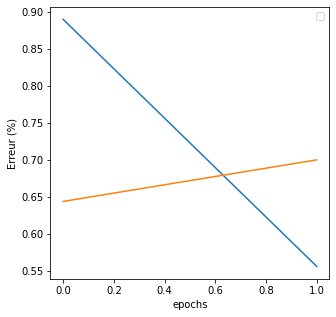

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.ylabel('Erreur (%)')
plt.xlabel('epochs')
plt.legend()

No handles with labels found to put in legend.


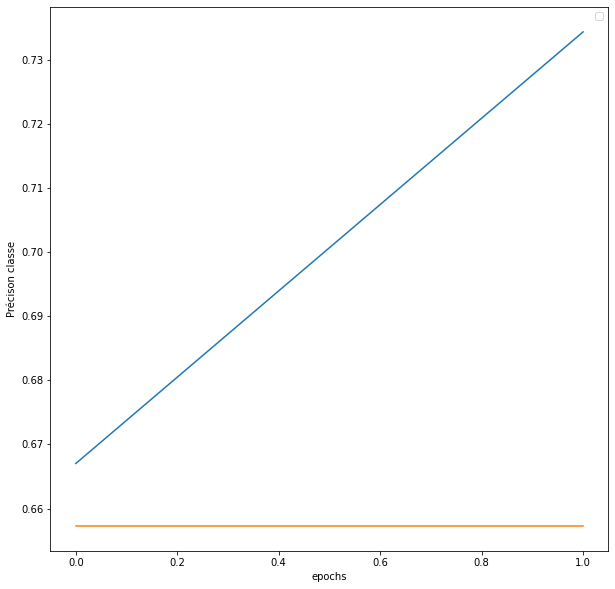

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.ylabel('Précison classe')
plt.xlabel('epochs')
plt.legend()

In [ ]:
model.evaluate(test_generator)

37/37 [==============================] - 194s 5s/step - loss: 0.7156 - accuracy: 0.6458


[0.7155543565750122, 0.6457627415657043]

==> 65% y'a pire :/

In [ ]:
modelbest.evaluate(test_generator)

37/37 [==============================] - 119s 3s/step - loss: 0.0434 - accuracy: 0.9809


[0.05592058598995209, 0.9779661297798157]

==> J'ai compris ....

- Matrice de confusion

In [ ]:
y_pred = model.predict(test_generator, steps = test_generator.n // 16, verbose = 1)
y_pred.shape

36/36 [==============================] - 117s 3s/step


(576, 2)

In [ ]:
test_generator.n //16

36

In [ ]:
# Obtenir la class predite du model
predict = []

for i in y_pred:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
test['mask'].shape

(590,)

In [ ]:
# Comme on a utilisé test_generator, la quantité produite n'est pas la même
y = np.asarray(test['mask'])[:len(y_pred)]
y.shape, predict.shape, y[0], predict[0]

((576,), (576,), '0', '0')

In [ ]:
predict

In [ ]:
len(y[y == '1'])

202

In [ ]:
# Acc score
from sklearn.metrics import accuracy_score

acc = accuracy_score(y, predict)
acc

0.6423611111111112

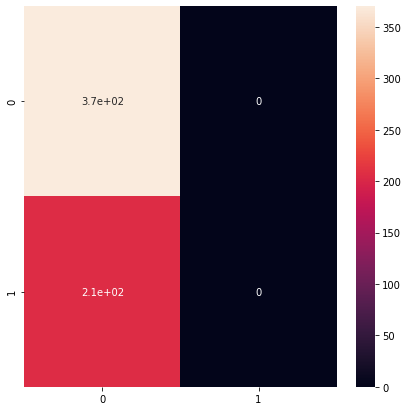

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True)

In [ ]:
cm

array([[247, 127],
       [131,  71]])

==> Ok mon modèle à du coup du mal (...) avec la detection de cancer ==> Il est INUTILE

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y, predict, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       370
           1       1.00      0.00      0.00       206

    accuracy                           0.64       576
   macro avg       0.82      0.50      0.39       576
weighted avg       0.77      0.64      0.50       576



- key Performance Indicator (Matrice de confusion, précision, rappel)

- La performance d'un modèle ne doit pas s'évaluer que sur la {Classification précision}, c'est une donnée insuffisante pour l'évaluation, car elle dépend bcp de l'équilbre données, voici les KPI a considérer :

  - **Classification Precision ou Justesse** :Désigne la proportion des prédictions correctes effectuées par le modèle
    - True P + True N / (TP + TN + FP + FN) ( correct on all population) => 370 + 0 / 370 + 0 + 210 + 0 = 0.63
  - **Taux d'erreur (%)** = FP + FN / population => 0 + 210 / 576 = 0.36

  - **Précision** : permet de répondre à la question suivante :
    - Quelle proportion d'identifications positives était effectivement correcte ?
    - Tp / (population des justes) = TP / (TP + FP)

      * classe 0 = 370 / ( 370 + 206) = 0.64
      * classe 1 = 206 / 0 + 206 = 1.00

  - **Le Rappel** : permet de répondre à la question suivante :
    - Quelle proportion de résultats positifs réels a été identifiée correctement ?
    - Rappel = TP / TP + FN 

![Precision&Rappel](https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Precisionrappel.svg/800px-Precisionrappel.svg.png)

  - La **Justesse** seule ne reflète pas la réalité de la situation quand nous travaillons sur un ensemble de données avec " déséquilibre des classes " comme celui-ci, où l'on constate une disproportion entre le nombre des étiquettes positives et négatives.

- # Performance modèle 2

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10), squeeze = False)
fig.tight_layout()
       
axs[0][0].plot(h.history['loss'])
axs[0][0].plot(h.history['val_loss'])
axs[0][0].ylabel('Erreur (%)')
axs[0][0].xlabel('epochs')
axs[0][0].legend()
axs[0][0].axis("off")
axs[0][0].set_title('Loss')

axs[0][1].plot(h.history['accuracy'])
axs[0][1].plot(h.history['val_accuracy'])
axs[0][1].ylabel('Précision')
axs[0][1].xlabel('epochs')
axs[0][1].legend()
axs[0][1].axis("off")
axs[0][1].set_title('Précision')

In [ ]:
model.evaluate(test_generator)

37/37 [==============================] - 161s 4s/step - loss: 0.2361 - accuracy: 0.8915


[0.24755781888961792, 0.8813559412956238]

=> Comparais aux résultat précédents loss: 0.7156 - accuracy: 0.6458, c'est déjà bien mieux (mêm si l'entrainement (c'est arrêté) !

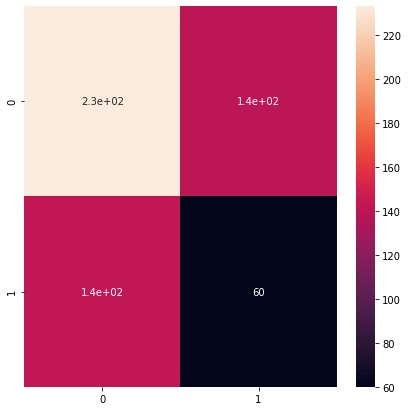

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True)

In [ ]:
cm

array([[233, 141],
       [142,  60]])

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y, predict, zero_division=1))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       374
           1       0.30      0.30      0.30       202

    accuracy                           0.51       576
   macro avg       0.46      0.46      0.46       576
weighted avg       0.51      0.51      0.51       576



In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y, predict, zero_division=1))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67       374
           1       0.40      0.39      0.39       202

    accuracy                           0.58       576
   macro avg       0.53      0.53      0.53       576
weighted avg       0.58      0.58      0.58       576



=> A relativiser, il y a du mieux, j'ai enfin une précision pour les cas de tumors, mais le rappel reste faible

Comparativement

In [ ]:
y_pred = modelbest.predict(test_generator, steps = test_generator.n // 16, verbose = 1)
y_pred.shape

36/36 [==============================] - 114s 3s/step


(576, 2)

In [ ]:
modelbest.evaluate(test_generator)

37/37 [==============================] - 118s 3s/step - loss: 0.0868 - accuracy: 0.9771


[0.06948374211788177, 0.9830508232116699]

In [ ]:
# Obtenir la class predite du model
predict = []

for i in y_pred:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

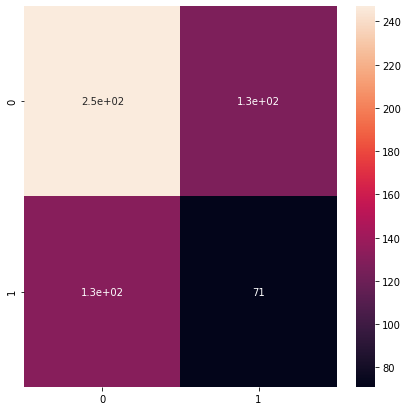

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True)

In [ ]:
cm

array([[247, 127],
       [131,  71]])

In [ ]:
print(classification_report(y, predict, zero_division=1))

              precision    recall  f1-score   support

           0       0.65      0.66      0.66       374
           1       0.36      0.35      0.35       202

    accuracy                           0.55       576
   macro avg       0.51      0.51      0.51       576
weighted avg       0.55      0.55      0.55       576



==> En faite mon modèle est **légérement*** meilleurs

Sur 374 cas sain, il n'en reconnait que 247 soit un rappel de 247/347 = 66% de cas reconnu. En d'autres termes, il identifie correctement 66 % des cas sains.

Sur 202 cas non-sain, il n'en reconnait que 71 soit 71/202 = 35% de cas reconnu

Le % d'erreur est de 131 + 127 / 576 = 44%
Se qui reste élevé

La précison pour les cas de tumeur est de 36% En d’autre termes, quand il prédit la presence d'une tumeur, sa prédiction est juste dans 36% des cas seulement.

- # Modèle perf re-entrainé

In [ ]:
model.evaluate(test_generator)

37/37 [==============================] - 118s 3s/step - loss: 0.2328 - accuracy: 0.8932


[0.23284992575645447, 0.8932203650474548]

In [ ]:
y_pred = model.predict(test_generator, steps = test_generator.n // 16, verbose = 1)

# Obtenir la class predite du model
predict = []

for i in y_pred:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

36/36 [==============================] - 115s 3s/step


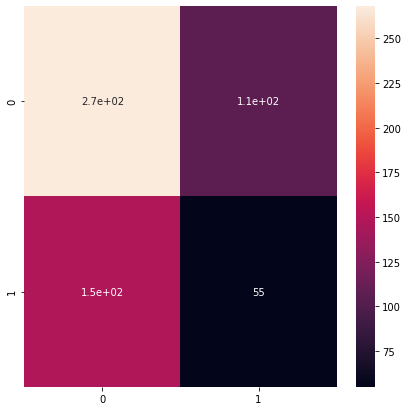

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True)

In [ ]:
print(classification_report(y, predict, zero_division=1))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       374
           1       0.34      0.27      0.30       202

    accuracy                           0.56       576
   macro avg       0.49      0.49      0.49       576
weighted avg       0.54      0.56      0.55       576



))> Pas mieux ...

- # ResUNet Segmentation

 U-Net ?

U-Net est un réseau de neurones à convolution développé pour la segmentation d'images biomédicales au département d'informatique de l'université de Fribourg en Allemagne. 

Le réseau est basé sur le **réseau entièrement convolutionnel** et son architecture a été modifiée et étendue pour fonctionner avec moins d’images d'entrainement et pour permettre une segmentation plus précise. La segmentation d'une image 512 * 512 prend moins d'une seconde sur un GPU récent.*

- Les opérations de pooling sont remplacées par des opérateurs de suréchantillonnage. Par conséquent, ces couches augmentent la résolution de la sortie. 

![img](https://upload.wikimedia.org/wikipedia/commons/2/2b/Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png)

The UNET was developed by Olaf Ronneberger et al. for Bio Medical Image Segmentation. The architecture contains two paths. 
  1. First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. 

  1. Partie Bootleneck - L'information encodé et compressé dans une couche 
  
  2. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it **only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size**.

  3. **Il s'agit donc d'un autoEncodeur puisque la taille de la sortie et la même que celle d'entrée**

  4. U-Net réalise une classification niveau pixel (segmentation) 

  5. L'entrée **X = Image scanner**, la sortie **y = Mask tumeur**

![img2](https://neurohive.io/wp-content/uploads/2018/11/u-net-x.png)

The cropping is necessary due to the loss of border pixels in every convolution.

![upsamp](https://miro.medium.com/max/2400/1*YVnd7rDV9HkchXx3C8Qljw.png)

![upsamp](https://miro.medium.com/max/479/1*AgW6sE-8xIPg-By9OSCT3w.png)

  ----

- Pourquoi Fully Convolutional Networks (FCN) ?

  - Convolutional neural networks (CNN) work great for computer vision tasks. Using a pre-trained model that is trained on huge datasets like ImageNet, COCO, etc. we can quickly specialize these architectures to work for our unique dataset. This process is termed as transfer learning. However, there’s a catch! **Pre-trained models for image classification and object detection tasks are usually trained on fixed input image sizes.**

  - FCN is a network that does not contain any “Dense” layers (as in traditional CNNs) instead it contains 1x1 convolutions that perform the task of fully connected layers (Dense layers).

  - looking at the math, "Convolution" layer and "InnerProduct" (aka "fully connected") layer are basically quite similar: they perform a linear operation on their respective receptive fields. The only difference is that "InnerProduct" takes the entire input as its "receptive field" while "Convolution" layer only looks at kernel_size window in the input.

  - What happens if the input size is changed?
"Convolution" layer cannot care less, it simply outputs the feature map with spatial dimensions corresponding to the new input shape.
On the other hand, "InnerProduct" layer fails since the number of weights it has does not match the new size of the receptive field.

Mêm si on fait une couche flatten. Puisque la taille de l'image d'entrée change (aug/dim), la taille de flatten en nombre de noeud augmente aussi, HORS la couche Dense suivante et construite pour supporter les connections (disons 1000) d'une taille de flatten prédéfini. Avec ce changement il devrait y avoir 1001 ou 999 connections par exemple au lieu de 1000 ce qui n'est pas l'architecture attendu par le réseau.
La problème se pose dèjà au niveau de flatten puisque les poids et connection étant fixé, la taille attendu de flatten l'est aussi. Impossible de gérer un changement de taille d'entrée. 

In [ ]:
from sklearn.model_selection import train_test_split

# On veut déduire le mask à partit des donnée en ayant un, donc on isole ces derniers
brain_df_mask = brain_df[brain_df['mask'] == 1]

# Séparer en partie train/test (RETOURE des Dataframe ici)
X_train, X_val = train_test_split(brain_df_mask, test_size = 0.15)
X_test, X_val = train_test_split(X_val, test_size = 0.5)

- Listes séparées

In [ ]:
train_ids = list('Brain_MRI/' + X_train.image_path)
train_mask = list('Brain_MRI/' + X_train.mask_path)

val_ids = list('Brain_MRI/' + X_val.image_path)
val_mask = list('Brain_MRI/' + X_val.mask_path)

In [ ]:
val_mask[0]

'TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_21_mask.tif'

- Code contenant une custom Loss et data  generator

In [ ]:
from Brain_MRI.utilities import DataGenerator

training_gen = DataGenerator(train_ids, train_mask, image_dir = 'Brain_MRI/')
validation_gen = DataGenerator(val_ids, val_mask, image_dir = 'Brain_MRI/')

In [ ]:
training_gen.image_dir

'Brain_MRI'

- Methode #2

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

train, test = train_test_split(brain_df_mask, test_size = 0.15)

# Générateur d'image dans un batch dont 15% pour la validation + scale data enre 0 et 1
datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.50)
train_generator = datagen.flow_from_dataframe(directory ='./Brain_MRI/', 
                                              target_size = (256, 256), 
                                              class_mode = 'categorical', 
                                              batch_size = 16, # feed the image in batch format
                                              shuffle = True, # Important de mélanger afin que le modèle n'apprenne l'ordre des images, ce qui lui ferai croire qu'il y a un pattern prédictif dans la sucession d'images
                                              dataframe = train,
                                              x_col = 'image_path',
                                              y_col = 'mask_path',
                                              subset = 'training')

# Les 15%
valid_generator = datagen.flow_from_dataframe(directory ='./Brain_MRI/', 
                                              target_size = (256, 256), 
                                              class_mode = 'categorical', 
                                              batch_size = 16, # feed the image in batch format
                                              shuffle = True,
                                              dataframe = train,
                                              x_col = 'image_path',
                                              y_col = 'mask_path',
                                              subset = 'validation')

# Pour test, j'utilise un autre générateur, car je ne veux pas diviser en valid la partie test qui est dejà un division de train
test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_dataframe(directory ='./Brain_MRI/', 
                                              target_size = (256, 256), 
                                              class_mode = 'categorical', 
                                              batch_size = 16, # feed the image in batch format
                                              shuffle = True,
                                              dataframe = test,
                                              x_col = 'image_path',
                                              y_col = 'mask_path')

Found 584 validated image filenames belonging to 1167 classes.
Found 583 validated image filenames belonging to 1167 classes.
Found 206 validated image filenames belonging to 206 classes.


- Définir un Resblock

In [ ]:
def resblock(X, f):

  X_copy = X

  # main

  X = Conv2D(f, kernel_size = (1, 1), strides = (1,1), kernel_initializer = 'he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3, 3), strides = (1,1), kernel_initializer = 'he_normal', padding = 'same')(X)
  X = BatchNormalization()(X)

  # Short

  X_copy = Conv2D(f, kernel_size = (1, 1), strides = (1,1), kernel_initializer = 'he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Add

  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  return X

- Up-sampling

In [ ]:
from keras.layers import UpSampling2D, Concatenate

def upsample_concat(x, skip):

  x = UpSampling2D(size = (2,2))(x) # Repeat the row and the columns of the data
  merge = Concatenate()([x, skip])

  return merge

- test

In [ ]:
input_shape = (2, 2, 1, 3)
x = np.arange(np.prod(input_shape)).reshape(input_shape)
#print(x)
"""
[[[[ 0  1  2]]
  [[ 3  4  5]]]
 [[[ 6  7  8]]
  [[ 9 10 11]]]]
"""
y = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
print(y)

tf.Tensor(
[[[[ 0  1  2]
   [ 0  1  2]]

  [[ 0  1  2]
   [ 0  1  2]]

  [[ 3  4  5]
   [ 3  4  5]]

  [[ 3  4  5]
   [ 3  4  5]]]


 [[[ 6  7  8]
   [ 6  7  8]]

  [[ 6  7  8]
   [ 6  7  8]]

  [[ 9 10 11]
   [ 9 10 11]]

  [[ 9 10 11]
   [ 9 10 11]]]], shape=(2, 4, 2, 3), dtype=int64)


- Le reste

In [ ]:
input = Input(shape = (256,256,3))

# Stage 1
conv_in = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
conv_in = BatchNormalization()(conv_in)
conv_in = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_in)
conv_in = BatchNormalization()(conv_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv_in)

# Stage 2
conv_in2 = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv_in2)

# Stage 3
conv_in3 = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv_in3)

# Stage 4
conv_in4 = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv_in4)

# Stage 5 (bottleneck)
conv_in5 = resblock(pool_4, 256)

# --------------------

# Upscale 1
up_1 = upsample_concat(conv_in5, conv_in4)
up_1 = resblock(up_1, 128)

# Upscale 2
up_2 = upsample_concat(up_1, conv_in3)
up_2 = resblock(up_2, 64)

# Upscale 3
up_3 = upsample_concat(up_2, conv_in2)
up_3 = resblock(up_3, 32)

# Upsclae 4
up_4 = upsample_concat(up_3, conv_in)
up_4 = resblock(up_4, 16)

output = Conv2D(1, (1,1), padding = 'same', activation = 'sigmoid')(up_4)

model_segmentation = Model(inputs = input, outputs = output)
model_segmentation.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

- # Charger modèle (si existe)

In [ ]:
model_segmentation.load_weights('reUsnet-weights.hdf5')

# retarin the model where it stop 
h = model_segmentation.fit(training_gen, epochs = 15, validation_data = validation_gen, callbacks = [checkpoint, early_stopping])

Epoch 1/15
72/72 [==============================] - 765s 10s/step - loss: 0.5812 - tversky1: 0.5143 - val_loss: 0.5768 - val_tversky1: 0.5173

Epoch 00001: val_loss improved from inf to 0.57679, saving model to reUsnet-weights.hdf5
Epoch 2/15
72/72 [==============================] - 670s 9s/step - loss: 0.5762 - tversky1: 0.5193 - val_loss: 0.5728 - val_tversky1: 0.5237

Epoch 00002: val_loss improved from 0.57679 to 0.57285, saving model to reUsnet-weights.hdf5
Epoch 3/15
72/72 [==============================] - 667s 9s/step - loss: 0.5669 - tversky1: 0.5297 - val_loss: 0.5425 - val_tversky1: 0.5566

Epoch 00003: val_loss improved from 0.57285 to 0.54250, saving model to reUsnet-weights.hdf5
Epoch 4/15
72/72 [==============================] - 654s 9s/step - loss: 0.5501 - tversky1: 0.5481 - val_loss: 0.5234 - val_tversky1: 0.5778

Epoch 00004: val_loss improved from 0.54250 to 0.52337, saving model to reUsnet-weights.hdf5
Epoch 5/15
72/72 [==============================] - 653s 9s/ste

==> 3ième affinage, on arrive à 74%, c'est meiux que mes 15% du début reste à voir au Sanity Check

- # Train ;!

- On a besin d'une Fonction Loss custom pour Resunet, j'ai trouver celle-ci https://github.com/nabsabraham/focal-tversky-unet.git

In [ ]:
def tversky1(y_true, y_pred, smooth = 1e-6):

    """
      J'ai apporté une correction en castant les tenseur, car j'avais des problème au niveau des opération entre int64 et float32
    """
    y_true_pos = tf.cast(K.flatten(y_true), dtype = tf.float32)
    y_pred_pos = tf.cast(K.flatten(y_pred), dtype = tf.float32)

    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = tf.cast(K.sum(y_true_pos * (1-y_pred_pos)), dtype = tf.float32)
    false_pos = tf.cast(K.sum((1-y_true_pos)*y_pred_pos), dtype = tf.float32)
    alpha = 0.7

    """
    print(y_true_pos)
    print(y_pred_pos)
    print(false_neg)
    print(false_pos)
    """
    
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss1(y_true, y_pred):
    return 1 - tversky1(y_true,y_pred)

def focal_tversky1(y_true,y_pred):
    pt_1 = tversky1(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
from Brain_MRI.utilities import focal_tversky, tversky_loss, tversky
from keras.optimizers import Adam

model_segmentation.compile(optimizer = Adam(learning_rate = 0.001, epsilon = 0.1), loss = focal_tversky1, metrics = [tversky1])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 5)

checkpoint = ModelCheckpoint(filepath= 'reUsnet-weights.hdf5', verbose = 1, save_best_only = True)

In [ ]:
h = model_segmentation.fit(training_gen, epochs = 15, validation_data = validation_gen, callbacks = [checkpoint, early_stopping])

Epoch 1/15
72/72 [==============================] - 702s 10s/step - loss: 0.8770 - tversky1: 0.1605 - val_loss: 0.8631 - val_tversky1: 0.1781

Epoch 00001: val_loss improved from inf to 0.86314, saving model to reUsnet-weights.hdf5
Epoch 2/15
72/72 [==============================] - 701s 10s/step - loss: 0.8719 - tversky1: 0.1669 - val_loss: 0.8571 - val_tversky1: 0.1857

Epoch 00002: val_loss improved from 0.86314 to 0.85711, saving model to reUsnet-weights.hdf5
Epoch 3/15
72/72 [==============================] - 709s 10s/step - loss: 0.8646 - tversky1: 0.1762 - val_loss: 0.8574 - val_tversky1: 0.1852

Epoch 00003: val_loss did not improve from 0.85711
Epoch 4/15
72/72 [==============================] - 690s 10s/step - loss: 0.8577 - tversky1: 0.1849 - val_loss: 0.8438 - val_tversky1: 0.2025

Epoch 00004: val_loss improved from 0.85711 to 0.84379, saving model to reUsnet-weights.hdf5
Epoch 5/15
72/72 [==============================] - 686s 10s/step - loss: 0.8495 - tversky1: 0.1953 - 

- # Save le modèle Architecture

In [ ]:
model_jon = model_segmentation.to_json()

with open('ResUnet-archit.json', 'w') as json_file:
  json_file.write(model_jon)

- # Pred & Perfs

In [ ]:
# Ajouter le chemin complet danas le dataframe pour eviter l'erreur : no such file or directory cz prediction ne permet de specif un rep (bien que je peux aussi modifier la fonction)
test['image_path'] = test['image_path'].apply( lambda x : 'Brain_MRI/' + x)
test['mask_path'] = test['mask_path'].apply( lambda x : 'Brain_MRI/' + x)

test.head(2)

,patient_id,image_path,mask_path,mask
3227,TCGA_HT_A61A_20000127,Brain_MRI/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,Brain_MRI/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,1
1220,TCGA_DU_7008_19830723,Brain_MRI/TCGA_CS_6669_20020102/TCGA_CS_6669_2...,Brain_MRI/TCGA_CS_6669_20020102/TCGA_CS_6669_2...,1


In [ ]:
from Brain_MRI.utilities import prediction

# Cette fonction va prendre les 2 modèle, et consécutivement si le premier donne son avale (tumeur existe alors le 2ième prédit l'emplaement par segmentation)
img_ig, mask, has_mask = prediction(test, modelbest, model_segmentation)

- Créer un Dataframe des résultats

In [ ]:
df_pred = pd.DataFrame({'image_path' : img_ig, 'prediction_mask' : mask, 'has_mask ?' : has_mask})
df_pred.head(10)

,image_path,prediction_mask,has_mask ?
0,Brain_MRI/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,"[[[[0.36337644], [0.17490909], [0.25698847], [...",1
1,Brain_MRI/TCGA_CS_6669_20020102/TCGA_CS_6669_2...,"[[[[0.3432786], [0.08644655], [0.21323678], [0...",1
2,Brain_MRI/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_1...,"[[[[0.28126964], [0.14301524], [0.18123263], [...",1
3,Brain_MRI/TCGA_FG_7643_20021104/TCGA_FG_7643_2...,"[[[[0.31577396], [0.17014596], [0.22775897], [...",1
4,Brain_MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_1...,"[[[[0.32688302], [0.16318351], [0.26421133], [...",1
5,Brain_MRI/TCGA_FG_5962_20000626/TCGA_FG_5962_2...,"[[[[0.32123446], [0.13900906], [0.16734129], [...",1
6,Brain_MRI/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_2...,"[[[[0.30897525], [0.06225806], [0.11587584], [...",1
7,Brain_MRI/TCGA_DU_7008_19830723/TCGA_DU_7008_1...,"[[[[0.3155613], [0.14131567], [0.20492995], [0...",1
8,Brain_MRI/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,"[[[[0.22330156], [0.14564526], [0.20926946], [...",1
9,Brain_MRI/TCGA_FG_7637_20000922/TCGA_FG_7637_2...,"[[[[0.28517336], [0.09955296], [0.25187582], [...",1


- Mergeons Le dataFrame test & celui de prédiction 'INNER JOIN', pour comparer les résultats

In [ ]:
new_df = test.merge(df_pred, on = 'image_path')
new_df.head(10)

,patient_id,image_path,mask_path,mask,prediction_mask,has_mask ?
0,TCGA_HT_A61A_20000127,Brain_MRI/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,Brain_MRI/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,1,"[[[[0.36337644], [0.17490909], [0.25698847], [...",1
1,TCGA_DU_7008_19830723,Brain_MRI/TCGA_CS_6669_20020102/TCGA_CS_6669_2...,Brain_MRI/TCGA_CS_6669_20020102/TCGA_CS_6669_2...,1,"[[[[0.3432786], [0.08644655], [0.21323678], [0...",1
2,TCGA_FG_7637_20000922,Brain_MRI/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_1...,Brain_MRI/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_1...,1,"[[[[0.28126964], [0.14301524], [0.18123263], [...",1
3,TCGA_HT_7690_19960312,Brain_MRI/TCGA_FG_7643_20021104/TCGA_FG_7643_2...,Brain_MRI/TCGA_FG_7643_20021104/TCGA_FG_7643_2...,1,"[[[[0.31577396], [0.17014596], [0.22775897], [...",1
4,TCGA_HT_A61B_19991127,Brain_MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_1...,Brain_MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_1...,1,"[[[[0.32688302], [0.16318351], [0.26421133], [...",1
5,TCGA_CS_6667_20011105,Brain_MRI/TCGA_FG_5962_20000626/TCGA_FG_5962_2...,Brain_MRI/TCGA_FG_5962_20000626/TCGA_FG_5962_2...,1,"[[[[0.32123446], [0.13900906], [0.16734129], [...",1
6,TCGA_DU_7306_19930512,Brain_MRI/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_2...,Brain_MRI/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_2...,1,"[[[[0.30897525], [0.06225806], [0.11587584], [...",1
7,TCGA_DU_A5TT_19980318,Brain_MRI/TCGA_DU_7008_19830723/TCGA_DU_7008_1...,Brain_MRI/TCGA_DU_7008_19830723/TCGA_DU_7008_1...,1,"[[[[0.3155613], [0.14131567], [0.20492995], [0...",1
8,TCGA_HT_7475_19970918,Brain_MRI/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,Brain_MRI/TCGA_DU_6408_19860521/TCGA_DU_6408_1...,1,"[[[[0.22330156], [0.14564526], [0.20926946], [...",1
9,TCGA_HT_7602_19951103,Brain_MRI/TCGA_FG_7637_20000922/TCGA_FG_7637_2...,Brain_MRI/TCGA_FG_7637_20000922/TCGA_FG_7637_2...,1,"[[[[0.28517336], [0.09955296], [0.25187582], [...",1


In [ ]:
mask = new_df['prediction_mask'][0]
mask.shape # (1 , 256, 256, 1)
mask = np.asarray(mask)[0]
mask.shape # (256, 256, 1)
mask = np.squeeze(mask)
mask.shape

(256, 256)

- Sanity Check Visuel

In [ ]:
fig, axs = plt.subplots(nrows = 10, ncols = 5, figsize = (30, 40))

count = 0

for i in range(len(new_df)):

  if new_df['has_mask ?'][i] == 1 and count < 10:
    
    # l'Image IRM
    img = np.array(plt.imread(new_df['image_path'][i]))

    axs[count][0].title.set_text('IRM')
    axs[count][0].imshow(img, cmap = 'gray')

    # Le mask réel
    mask = plt.imread(new_df['mask_path'][i])

    axs[count][1].title.set_text('MAsk')
    axs[count][1].imshow(mask, cmap = 'gray')

    # Prédiction faite
    pred = np.asarray(new_df['prediction_mask'][i])[0].squeeze().round() # [0] = batch, queeze (256, 256, 1) ==> (256, 256) / Parce que plot n'aime pas les channel de 1 (voir aussi "IA Emotion")

    axs[count][2].title.set_text('Mask Prediction')
    axs[count][2].imshow(pred, cmap = 'gray')

    # IRM + Original mask
    img[mask == 255] = (255, 0, 0)

    axs[count][3].title.set_text('Original mask on IRM')
    axs[count][3].imshow(img, cmap = 'gray')

    # Pour le modèle maintenant ...
    img_ = np.array(plt.imread(new_df['image_path'][i]))
    img_[pred == 1] = (0, 0, 255)

    axs[count][4].title.set_text('Mask Prediction + IRM')
    axs[count][4].imshow(img_, cmap = 'gray')

    # cCount ++
    count +=1

fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

**`=> Bon c'est la kata pour le modèle 2, faut l'entrainer +`**

- # Pred & Perfs 2

In [ ]:
# Ajouter le chemin complet danas le dataframe pour eviter l'erreur : no such file or directory cz prediction ne permet de specif un rep (bien que je peux aussi modifier la fonction)
test['image_path'] = test['image_path'].apply( lambda x : 'Brain_MRI/' + x)
test['mask_path'] = test['mask_path'].apply( lambda x : 'Brain_MRI/' + x)

test.head(2)

In [ ]:
from Brain_MRI.utilities import prediction

# Cette fonction va prendre els 2 modèle, et consécutivement si le premier donne son avale (umeor alors le 2ième prdit l'emplaement par segmentation)
img_ig, mask, has_mask = prediction(test, modelbest, model_segmentation)

In [ ]:
df_pred = pd.DataFrame({'image_path' : img_ig, 'prediction_mask' : mask, 'has_mask ?' : has_mask})
df_pred.head(10)

,image_path,prediction_mask,has_mask ?
0,Brain_MRI/TCGA_HT_7856_19950831/TCGA_HT_7856_1...,"[[[[0.00137284], [0.00156632], [0.00169653], [...",1
1,Brain_MRI/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_2...,"[[[[0.00013807], [0.00042319], [0.001681], [0....",1
2,Brain_MRI/TCGA_HT_7616_19940813/TCGA_HT_7616_1...,No mask,0
3,Brain_MRI/TCGA_CS_6667_20011105/TCGA_CS_6667_2...,"[[[[0.00159058], [0.00188681], [0.00286981], [...",1
4,Brain_MRI/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,"[[[[0.00139982], [0.00159749], [0.0014973], [0...",1
5,Brain_MRI/TCGA_DU_6405_19851005/TCGA_DU_6405_1...,No mask,0
6,Brain_MRI/TCGA_CS_6290_20000917/TCGA_CS_6290_2...,No mask,0
7,Brain_MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_1...,No mask,0
8,Brain_MRI/TCGA_DU_5855_19951217/TCGA_DU_5855_1...,No mask,0
9,Brain_MRI/TCGA_FG_6690_20020226/TCGA_FG_6690_2...,No mask,0


In [ ]:
new_df = test.merge(df_pred, on = 'image_path')
new_df.head(11)

,image_path,mask_path,mask,prediction_mask,has_mask ?
0,Brain_MRI/TCGA_HT_7856_19950831/TCGA_HT_7856_1...,Brain_MRI/TCGA_HT_7856_19950831/TCGA_HT_7856_1...,1,"[[[[0.00137284], [0.00156632], [0.00169653], [...",1
1,Brain_MRI/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_2...,Brain_MRI/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_2...,1,"[[[[0.00013807], [0.00042319], [0.001681], [0....",1
2,Brain_MRI/TCGA_HT_7616_19940813/TCGA_HT_7616_1...,Brain_MRI/TCGA_HT_7616_19940813/TCGA_HT_7616_1...,0,No mask,0
3,Brain_MRI/TCGA_CS_6667_20011105/TCGA_CS_6667_2...,Brain_MRI/TCGA_CS_6667_20011105/TCGA_CS_6667_2...,1,"[[[[0.00159058], [0.00188681], [0.00286981], [...",1
4,Brain_MRI/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,Brain_MRI/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,1,"[[[[0.00139982], [0.00159749], [0.0014973], [0...",1
5,Brain_MRI/TCGA_DU_6405_19851005/TCGA_DU_6405_1...,Brain_MRI/TCGA_DU_6405_19851005/TCGA_DU_6405_1...,0,No mask,0
6,Brain_MRI/TCGA_CS_6290_20000917/TCGA_CS_6290_2...,Brain_MRI/TCGA_CS_6290_20000917/TCGA_CS_6290_2...,0,No mask,0
7,Brain_MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_1...,Brain_MRI/TCGA_DU_6404_19850629/TCGA_DU_6404_1...,0,No mask,0
8,Brain_MRI/TCGA_DU_5855_19951217/TCGA_DU_5855_1...,Brain_MRI/TCGA_DU_5855_19951217/TCGA_DU_5855_1...,0,No mask,0
9,Brain_MRI/TCGA_FG_6690_20020226/TCGA_FG_6690_2...,Brain_MRI/TCGA_FG_6690_20020226/TCGA_FG_6690_2...,0,No mask,0


In [ ]:
new_df[new_df['mask'] == 1].head(5)

,image_path,mask_path,mask,prediction_mask,has_mask ?
0,Brain_MRI/TCGA_HT_7856_19950831/TCGA_HT_7856_1...,Brain_MRI/TCGA_HT_7856_19950831/TCGA_HT_7856_1...,1,"[[[[0.00137284], [0.00156632], [0.00169653], [...",1
1,Brain_MRI/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_2...,Brain_MRI/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_2...,1,"[[[[0.00013807], [0.00042319], [0.001681], [0....",1
3,Brain_MRI/TCGA_CS_6667_20011105/TCGA_CS_6667_2...,Brain_MRI/TCGA_CS_6667_20011105/TCGA_CS_6667_2...,1,"[[[[0.00159058], [0.00188681], [0.00286981], [...",1
4,Brain_MRI/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,Brain_MRI/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,1,"[[[[0.00139982], [0.00159749], [0.0014973], [0...",1
16,Brain_MRI/TCGA_FG_5962_20000626/TCGA_FG_5962_2...,Brain_MRI/TCGA_FG_5962_20000626/TCGA_FG_5962_2...,1,"[[[[0.00023291], [0.00099227], [0.00074241], [...",1


- Instant vérité (((

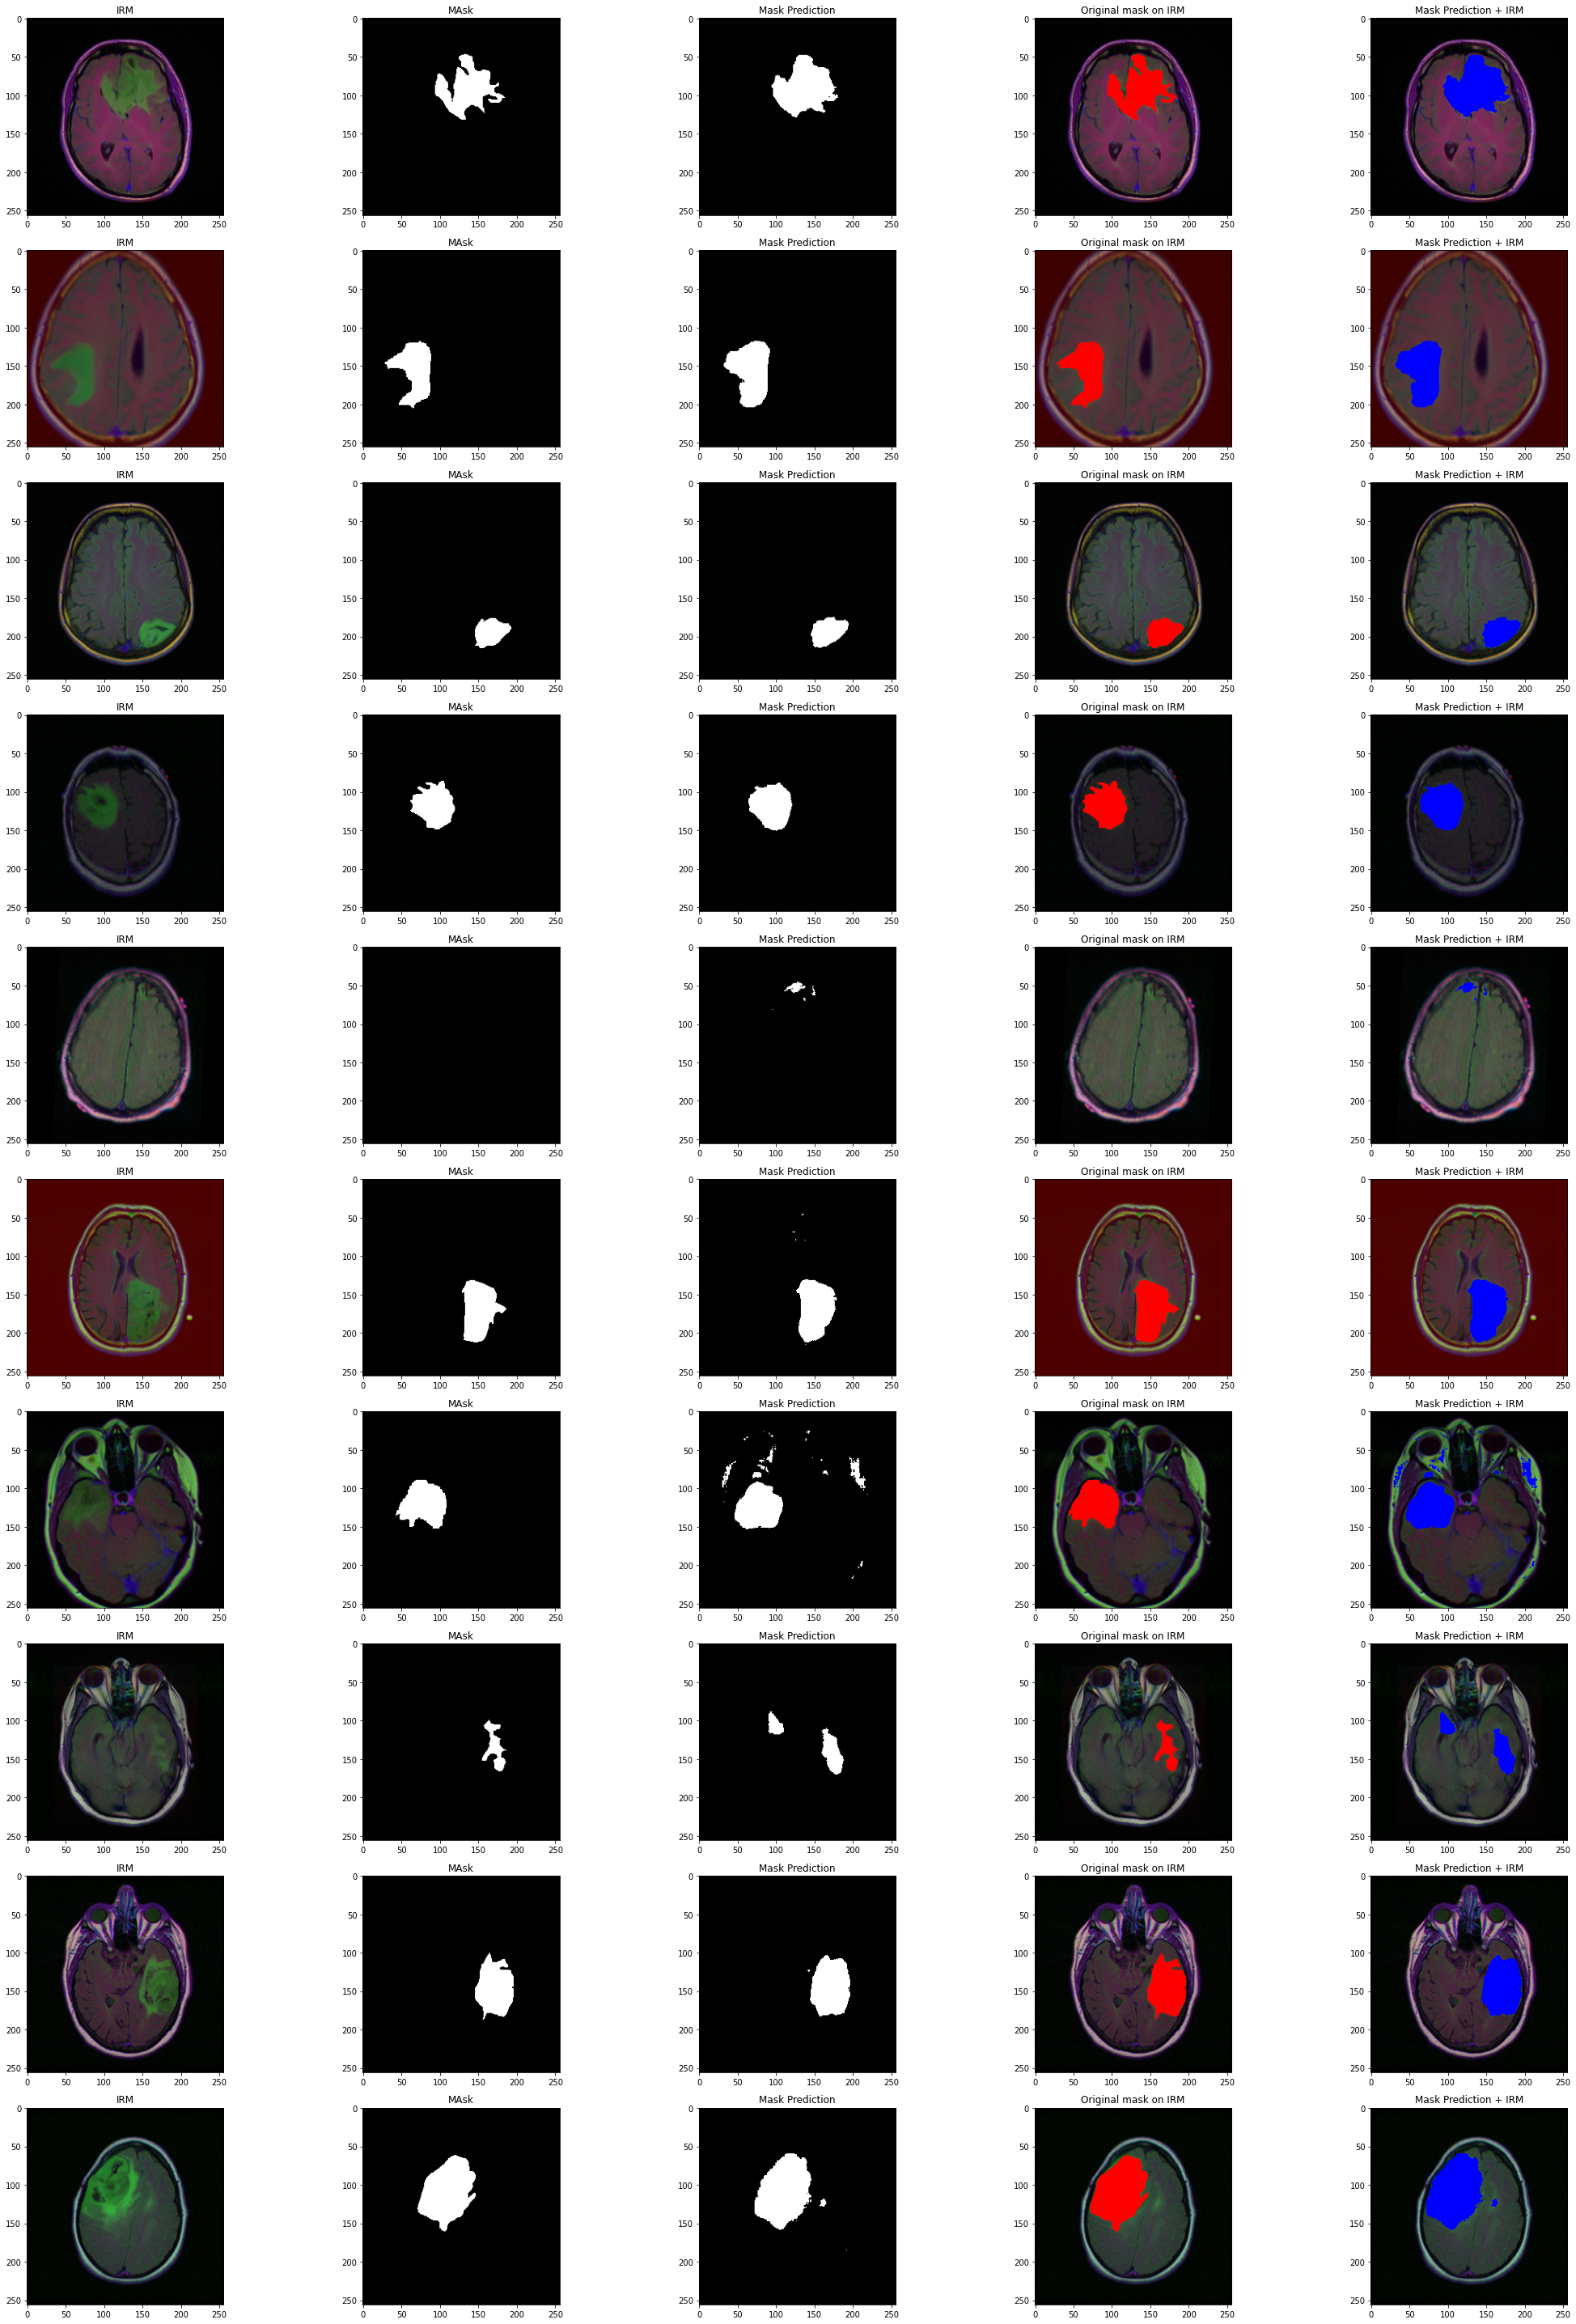

In [ ]:
fig, axs = plt.subplots(nrows = 10, ncols = 5, figsize = (30, 40))

count = 0

for i in range(len(new_df)):

  if new_df['has_mask ?'][i] == 1 and count < 10:
    
    # l'Image IRM
    img = np.array(plt.imread(new_df['image_path'][i]))

    axs[count][0].title.set_text('IRM')
    axs[count][0].imshow(img, cmap = 'gray')

    # Le mask réel
    mask = plt.imread(new_df['mask_path'][i])

    axs[count][1].title.set_text('MAsk')
    axs[count][1].imshow(mask, cmap = 'gray')

    # Prédiction faite
    pred = np.asarray(new_df['prediction_mask'][i])[0].squeeze().round() # [0] = batch, queeze (256, 256, 1) ==> (256, 256) / Parce que plot n'aime pas les channel de 1 (voir aussi "IA Emotion")

    axs[count][2].title.set_text('Mask Prediction')
    axs[count][2].imshow(pred, cmap = 'gray')

    # IRM + Original mask
    img[mask == 255] = (255, 0, 0)

    axs[count][3].title.set_text('Original mask on IRM')
    axs[count][3].imshow(img, cmap = 'gray')

    # Pour le modèle maintenant ...
    img_ = np.array(plt.imread(new_df['image_path'][i]))
    img_[pred == 1] = (0, 0, 255)

    axs[count][4].title.set_text('Mask Prediction + IRM')
    axs[count][4].imshow(img_, cmap = 'gray')

    # cCount ++
    count +=1

fig.tight_layout()

- Ligne 5 est un exemple d'une mauvaise prédiction du modèle 1 (faux positif), il n'y pas de tumeurs

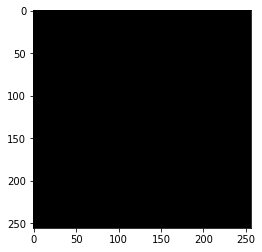

In [ ]:
img = plt.imread(new_df['mask_path'][10])
plt.imshow(img, cmap = 'gray')

No handles with labels found to put in legend.


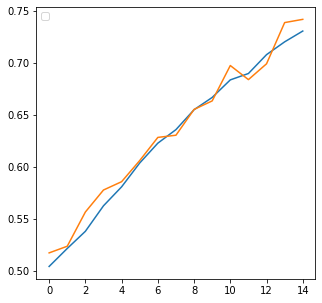

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(h.history['tversky1'])
plt.plot(h.history['val_tversky1'])
plt.xlabel('Epochs')
plt.legend()
plt.show()

No handles with labels found to put in legend.


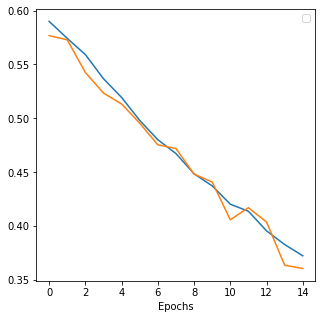

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.xlabel('Epochs')
plt.legend()
plt.show()